# Import of libraries and data sets

In [5]:
from typing import List, Union
import pandas as pd
import re
import numpy as np
from scipy.fft import fft, fftfreq
from scipy.signal import periodogram
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE
from scipy.stats import skew
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV,StratifiedKFold
from sklearn.linear_model import LogisticRegression

In [6]:
df = pd.read_csv("train.csv")
test_df =  pd.read_csv("test.csv")

# Functions for feature extraction

Our setup : we have for 663 observations, in different potions and different observation times, 24 devices recording measurements in the form of timeseries of length 2048.

### Max power spectrum

Our first approach involves switching from time space to frequency space using the Fast Fourier Transform.

In our case we therefore choose, despite the fact that the temporal extent of the individual timeseries is **unknown,** to evaluate the power spectrum and for the first half of the frequencies and extract features in the following way:
1. calculate the power spectrum by means of the fourier transform;
2. take only the real part of the power spectrum (applying abs);
3. do thethe square of magnitudes
4. divide the frequency axis (x-axis) into bin;
5. for each bin take the maximum power spectrum (magnitude).

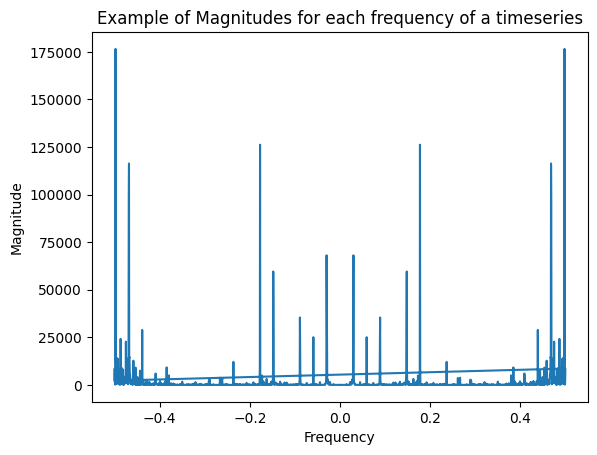

In [7]:
sample_ts= df.iloc[0,5:2053] # take a sampling time series
fourier_data = fft(sample_ts) # take the magnitudes
magnitudes = np.abs(fourier_data)**2
n = len(sample_ts)
freq = fftfreq(n)
plt.plot(freq, magnitudes)
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.title("Example of Magnitudes for each frequency of a timeseries")
plt.show()

This will be the function we are going to use for the extraction of this features

In [8]:
def maxbin(row: Union[List[float], np.ndarray], n_bins: int = 10) -> List[float]:
    """
    Divide the data into a specified number of bins and calculate the maximum value for each bin.

    Args:
        row (list or array): The data to be divided into bins.
        num_bins (int, optional): The number of bins to divide the data into. Defaults to 10.

    Returns:
        list: A list containing the maximum value for each bin.
    """
    n = len(row)
    step = n//n_bins
    max_values = []
    for i in range(0, n+1, step):
        if i==0:
            prec = i
            continue
        max_values.append(max(row[prec: i]))
        prec = i 
    return max_values


def fourier_magnitudes(signal: np.ndarray, n_bins: int = 10) -> np.ndarray:
    """
    This function takes a matrix (signal) which contains a time series for each row.
    It applies the Fast Fourier Transform and uses the get_max_per_bin function to find the maximum peaks for each bin of the arrays of the power spectrum for the FFT.

    Args:
        signal (np.ndarray): The input matrix, where each row represents a time series.
        num_bins (int, optional): The number of bins to divide the data into. Defaults to 10.

    Returns:
        np.ndarray: The maximum peaks for each bin of the arrays of the power spectrum for the FFT.
    """
    signal= np.array(signal)
    # let's calculate the FFT
    magnitudes = np.apply_along_axis(fft, 0, signal) 
    # extract just the first half of power spectrum and discover the peaks 
    magnitudes=magnitudes[:((magnitudes.shape[0])//2),:]
    # apply power spectrum formula
    magnitudes = np.abs(magnitudes)**2 
    # take the peaks for each bin
    peaks = np.apply_along_axis(lambda x: maxbin(x, n_bins), 0, magnitudes)
    
    return peaks

### Power spectral density

Power spectral density (PSD) shows how the power of a signal is distributed over frequencies. Periodograms are a particular version of PSDs applied for discrete-time signals and we are going to use them to evaluate our PSD. We decide to extract 3 main summaries form this distribution since seems to be important for tasks related to anomaly detection and vibration/accelerometer analysis:
1. median of the PSD;
2. mean absolute deviation (generally nice in combo with the median);
3. skewness of the PSD.

In [9]:
def psd_stats(signal: np.ndarray) -> np.ndarray:
    """
    This function takes a matrix (signal) which contains a time series for each row.
    It calculates the Power Spectral Density (PSD) from the signal and returns three different summary statistics
    from the distribution of PSD: the median, the mean absolute deviation, and the skewness (third moment).

    Args:
        signal (np.ndarray): The input matrix, where each row represents a time series.

    Returns:
        np.ndarray: An array containing the median, mean absolute deviation, and skewness of the Power Spectral Density.
    """
    signal= np.array(signal)
    # let's calculate the Power Spectral Density
    psd = np.array(np.abs(np.apply_along_axis(periodogram, 0, signal)[1]), dtype=np.float64)
    
    # extract our main summaries from the distribution
    median = np.median(psd, axis=0)
    # calculate the third moment (skewness)
    third_moment = skew(psd, axis=0)
    # calculate the mean absolute deviation
    mad = np.mean(np.abs(psd - np.mean(psd, axis=0)), axis = 0)
    
    return np.array([median, mad, third_moment])

### Autocorrelation for different lags

In [10]:
def acf(signal: np.ndarray, n_lags: int = 10) -> np.ndarray:
    """
    This function takes a matrix (signal) which contains a time series for each row.
    It calculates the auto-correlation for different lags.

    Args:
        signal (np.ndarray): The input matrix, where each row represents a time series.
        num_lags (int, optional): The number of lags to calculate the auto-correlation for. Defaults to 10.

    Returns:
        np.ndarray: The auto-correlation for each time series in the input matrix.
    """
    signal= np.array(signal)
    autocorrelations = np.apply_along_axis(lambda x: sm.tsa.acf(x, nlags=n_lags), 0, signal)

    return autocorrelations

### Other functions for pre-processing

We also planned to introduce other features in addition to those described above:
>- Season: extracted from the "when" column of the original data set, inidicates the season in which the measurement is taken;
>- Elapsed time: again extracted from the "when" column and indicates the number of months passed since the first month of observation.

In [11]:
def adjust_df(s: pd.Series) -> pd.DataFrame:
    """
    This function takes a pandas Series, explodes and transposes it, and returns it as a DataFrame.

    Args:
        series (pd.Series): The input pandas Series.

    Returns:
        pd.DataFrame: The adjusted DataFrame.
    """
    df_list = [pd.DataFrame(matrix, index=[index]*len(matrix)) for index, matrix in s.items()]
    new_df = pd.concat(df_list, axis=0)
    new_df.columns = range(new_df.shape[1])
    new_df = new_df.T
    return new_df


def get_season(date):
    if date.month in [3, 4, 5]:
        return 1 # spring
    elif date.month in [6, 7, 8]:
        return 2 # summer
    elif date.month in [9, 10, 11]:
        return 3 # autumn
    else:
        return 4 # winter

# Data preparation and feature extraction (high dimensionality)

In [12]:
def preproc(df, n_bins=10, n_lags=10):
    
    # group timeseries by accelerometer (device)
    group_dict = {}
    for col in df.columns:
        match = re.match("^([A-Z1-9]{3})", col)
        group_dict[col] = match.group() if match else None

    new_df = df.T.groupby(group_dict, axis=0)

    # evaluate max magnitudes (intesities of the frequencies from Fourier Fast transform) for each observation for each accelerometer
    magns = new_df.apply(lambda x: fourier_magnitudes(x, n_bins))
    # evaluate autocorrelations
    autocorrs = new_df.apply(lambda x: acf(x, n_lags))
    # evaluate psd stats
    psds = new_df.apply(psd_stats)

    # adjust in DataFrame format
    magns = adjust_df(magns)
    autocorrs = adjust_df(autocorrs)
    psds = adjust_df(psds)

    # change col names of our dataframe of magnitudes
    existing_columns = magns.columns
    # generate a list of new column names
    new_columns = []
    i=1
    for j,col_name in enumerate(existing_columns):
        if ((j+1)%(n_bins+1)) == 0:
            i=1
        new_columns.append(f"{col_name}_mag_max_{i}")
        i+=1
    magns.columns = new_columns

    # change col names of our dataframe of autocorrelations
    existing_columns = autocorrs.columns
    # generate a list of new column names
    new_columns = []
    i=0
    for j,col_name in enumerate(existing_columns):
        if ((j+1)%(n_lags+2)) == 0:
            i=0
        new_columns.append(f"{col_name}_acf_l{i}")
        i+=1
    autocorrs.columns = new_columns

    # remove all the column which correspond to autocorrelation with lag=0
    autocorrs = autocorrs.loc[:, (autocorrs != 1).any(axis=0)]

    # change col names of our dataframe of autocorrelations
    existing_columns = psds.columns
    # generate a list of new column names
    new_columns = []
    i=1
    n_stats = 3
    for j,col_name in enumerate(existing_columns):
        new_columns.append(f"{col_name}_psd{i}")
        if ((j+1)%(n_stats)) == 0:
            i=0
        i+=1
    psds.columns = new_columns

    # create new column 'Season' based on 'when'
    df['when'] = pd.to_datetime(df['when'], format='%Y-%m')
    df["Season"] = df['when'].apply(get_season)

    # take the number of moths passed from the 'zero' time
    min_date =  df['when'].min()
    df['elapsed_time'] = (df['when'].dt.year - min_date.year) * 12 + (df['when'].dt.month - min_date.month)
    
    new_df = pd.concat([df[["Season", "elapsed_time"]], magns, autocorrs, psds], axis=1)

    return new_df

In [31]:
train = preproc(df)
test = preproc(test_df)

### Import the dataset of correlations

We thought of evaluating time series correlations between different measurement points on the compressor. To do this we reused the procedure developed in the second homework as well, only this time we have 3 classes and not 2. We need to build a unique dataset for each class by putting the time series as rows. In this way our new datasets will have as number of rows the absolute frequencies of the class for the length of the time series and as columns 24, which is the number of different points of measuraments. In addition, we constructed 3 other datasets in which the 2 different classes than the reference class are present, changing the re-reference class each time. Then in this way we created the graphs of the differences between the correlations of the reference class versus the correlation of the other two classes put together, in a kind of one vs all approach, so as to see if there are relevant differences in the correlations between two point in that class versus the other. This procedure was done for each class, and once a certain threshold was used, we selected the common variables. To take advantage of the code previously we worked on R and exported the 21 variables, these are the correlations that show a greater difference in one class than the others and could be useful for classification.

In [32]:
corr_train=pd.read_csv("train_a.csv")
corr_test=pd.read_csv("test_b.csv")

In [33]:
train=pd.concat([train,corr_train],axis=1)
test=pd.concat([test,corr_test], axis=1)

# Scaling the data set

We note that groups of columns have different sizes so we opt for (robust) standardization by columns in our dataframe in order to make the different features comparable and not get strange values for the parameters of our model. It is particularly useful when working with data that contain outliers or scattered values and it's computed as following:

$$
X_{\text {scale }}=\frac{x_i-x_{\mathrm{med}}}{x_{75}-x_{25}}
$$

In [34]:
#Scale data with RobustScaler 
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
col=train.columns
X_tr_scaled = pd.DataFrame(scaler.fit_transform(train),columns=col)
X_te_scaled = pd.DataFrame(scaler.fit_transform(test),columns=col )
X_te_scaled

,Season,elapsed_time,E1A_mag_max_1,E1A_mag_max_2,E1A_mag_max_3,E1A_mag_max_4,E1A_mag_max_5,E1A_mag_max_6,E1A_mag_max_7,E1A_mag_max_8,...,cor_E2P_M2P,cor_E3P_E4P,cor_E3P_M1P,cor_E3P_M2P,cor_E3V_E4A,cor_E3V_E4V,cor_E4A_E4H,cor_E4P_M2P,cor_M1A_M2A,cor_M1P_M2P
0,1.0,0.638298,-0.053077,-0.262788,0.047737,-0.242141,-0.169405,-0.221405,-0.215468,-0.232382,...,-0.511122,-0.254089,0.096485,-0.548342,1.769077,0.091947,0.726240,-0.476365,0.001820,-1.332654
1,-0.5,0.680851,-0.072831,-0.266944,-0.349170,-0.152923,0.557963,8.095217,-0.112630,0.505699,...,0.612548,-0.220519,-1.113509,0.697665,2.088551,0.484775,-0.262615,0.257704,-0.460445,-0.224991
2,0.5,-0.446809,-0.075265,-0.297735,-0.293777,-0.248054,-0.185424,-0.242364,-0.142257,-0.231727,...,0.368787,-1.128125,1.083483,0.035716,-1.100787,0.939328,-0.343666,-0.026715,1.450220,1.111149
3,0.0,-0.510638,1.175205,5.244658,1.275429,-0.107898,-0.147076,-0.226465,-0.013965,0.314038,...,-0.325875,0.109699,-0.365506,0.646366,-0.360070,-0.081909,0.473251,-0.663408,0.628869,0.306305
4,0.5,-0.723404,0.022613,-0.264118,0.000000,3.791340,0.145261,0.105445,0.639288,1.300892,...,0.145265,1.123927,1.092905,-0.500491,-0.594256,-0.421169,0.091400,-0.547371,0.011724,0.607256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,0.0,-0.531915,1.234051,0.124932,2.840187,0.594311,-0.155921,0.063501,10.464636,10.876975,...,-1.035705,1.533840,-0.187597,-0.153438,0.215660,-1.240892,-0.280268,0.154121,0.502359,-0.038427
351,0.5,0.340426,3.358659,2.366177,0.709307,1.397244,0.219068,-0.012056,-0.058571,0.171578,...,-0.095510,-0.878416,0.240232,-0.070995,0.064262,0.338604,-0.749398,0.023011,0.107523,0.435311
352,-0.5,0.468085,-0.008211,-0.313141,-0.413022,-0.283238,-0.184331,-0.232822,-0.210426,-0.219666,...,0.221995,0.064987,0.245384,-1.329974,-2.078832,-0.821568,-0.608044,-0.649634,-0.128411,4.613754
353,0.0,0.531915,1.188247,2.389373,0.340484,1.075466,1.630573,4.197880,8.086532,24.843820,...,0.062246,-0.158405,0.518511,0.206861,-0.119173,-0.592147,-0.076729,-0.796327,-0.379058,0.321494


# Dimensionality reduction with PCA (failed)

Dimensionality Reduction with PCA (linear)\

In order to reduce our high dimensionality data with all the features extracted:
- Peaks of magnitudes at LHC compressors low frequencies;
- Autocorrelations among time series;
- correlations one versus all.

We tried to reduce the high dimensionality through a pincipal components analysis. PCA practically is a linear transformation of the variables that projects the original variables into a new Cartesian system in which the new variable with the highest variance is projected onto the first axis, the new variable, second in variance size, onto the second axis, and so on.
We have tried to focus the reduction on the explained variance of the components, paying the price of lost information about specific columns (specific peaks of power spectrum for example.)

In [ ]:
'''
from sklearn.decomposition import PCA
#Let's fit PCA
pca = PCA().fit(X_tr)
#display the percentage of total variance explained by each principal component#
print(pca.explained_variance_ratio_.shape)
'''

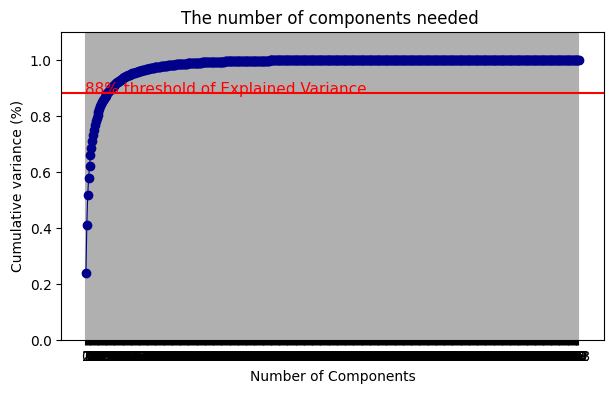        .   .     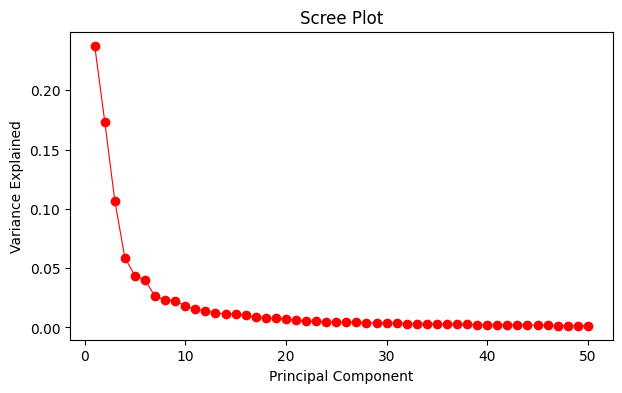

The plots above shows the cumulative variance increasing the number of principal components generated by PCA procedure.
Running our algorithms we noticed that, using principal component data on our classification algorithms the performances becomes worse. This may be due to the fact that during the process of dimensionality reduction, PCA may result in the loss of detailed information on individual columns of the original data. This happens because PCA operates on the basis of data variance and tries to reduce complexity by retaining only the most relevant information. The principal components identified by PCA are linear combinations of the original columns, so some column-specific information may be merged together or even eliminated in the projection process./
Due to this we decided to do not implement a PCA and use a model agnostic ***Permutation Importance*** procedure (as described in Elements of SL,chapter "15.3.2 Variable Importance") to filter our data and select the most important features

# Resampling with SMOTE

The data we are dealing with are strongly unbalanced with regard to the classes to be classified:

Label 1: 0.935143% of data;\
Label 2: 0.058824;\
Label 3: 0.006033.

To overcame this issue we have tried to use a SMOTE tecnique of over/under sampling.\
Please furthermore notice that, after a data exploration we noticed that:



In [17]:
df[df.y==3]

,id,main.pos,fun.pos,when,y,E1A1,E1A2,E1A3,E1A4,E1A5,...,M2V2041,M2V2042,M2V2043,M2V2044,M2V2045,M2V2046,M2V2047,M2V2048,Season,elapsed_time
19,29,LHCB-6,QSCB-6-CP7,2018-06-01,3,3.849429,-1.120215,1.900126,1.765498,-3.954946,...,-0.035500,-0.032582,0.158069,0.152430,0.453890,0.563897,0.683447,-0.023237,2,17
332,514,LHCB-6,QSCB-6-CP7,2017-11-01,3,-1.329898,-1.862015,-1.651927,-1.171916,0.036863,...,0.003700,-0.093183,0.167388,0.251590,0.381014,0.320008,0.095782,-0.094574,3,10
568,874,LHCB-6,QSCB-6-CP7,2017-12-01,3,1.988860,0.591283,1.497192,0.372399,1.557347,...,0.296484,0.025949,-0.071119,-0.088406,0.046136,-0.029481,0.014090,-0.267449,4,11
575,885,LHCB-8,QSCB-8-CP1,2020-10-01,3,-0.685269,0.234567,-0.149447,-0.076372,-0.050782,...,0.053421,0.123710,0.063862,0.047044,0.082810,-0.020352,0.063948,0.054148,3,45


three maximum alert level (label 3) have been detected by the same main position of sensors in the LHC. Generally LHCB main position seems to be a high risk position for "Big fail" alert level.

In [36]:
def resampling_strategy(train, y):
    counts = y.value_counts()
    total_new_train = int(np.ceil(counts[1]*100/70))
    sampling_strategy={2: int(np.ceil(total_new_train*0.25)), 3: int(np.floor(total_new_train*0.05))}
    return sampling_strategy

#smote = SMOTE(sampling_strategy=resampling_strategy(principalDf, df.y), k_neighbors=3)
smote = SMOTE(k_neighbors=3)#sampling_strategy=resampling_strategy(X_tr_scaled, df.y), k_neighbors=3)
X_train_resampled, y_train_resampled = smote.fit_resample(X_tr_scaled, df.y)  

# Feature importance

Find Variable Importance using Permutation importance as described in Elememnts Of SL book. Notice that we use a sort of cross validation on the different classifiers and compute the mean of all the importance scores. 

### PERMUTATION IMPORTANCE 

The main idea behind Permutation Importance is to measure how much the predictive performance of a model deteriorates when the values of a particular feature are randomly permuted. The Permutation Importance scores can be used to rank the features based on their importance. Features with higher scores are considered more influential in the model's predictions, while features with lower scores are deemed less important.

In [38]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

#PERMUTATION IMPORTANCE WITHout CROSS VALIDATION 
X_train, X_val, y_train, y_val = train_test_split(X_train_resampled,y_train_resampled)
model = LogisticRegression(multi_class='multinomial', class_weight="balanced",max_iter=1000,n_jobs=-1)
lr = model.fit(X_train, y_train-1)

r = permutation_importance(model, X_val, y_val, n_repeats=100, n_jobs=-1, random_state=0)
importance_df = pd.DataFrame()
importance_df["Features"] = X_tr_scaled.columns
importance_df['Importances'] = r.importances_mean


In [45]:
X_tr = X_train_resampled[importance_df[importance_df["Importances"] > 0.0002].Features.values]
X_tr

,E1A_mag_max_6,E1V_mag_max_7,E1V_mag_max_8,E2A_mag_max_11,E2H_mag_max_8,E2V_mag_max_8,E3H_mag_max_10,E3H_mag_max_11,E4A_mag_max_6,E4A_mag_max_7,...,M1H_mag_max_7,M1H_mag_max_8,M1H_mag_max_1,M1H_mag_max_5,M1V_mag_max_10,M2A_mag_max_1,M2H_mag_max_5,M2V_mag_max_4,E2A_psd2,cor_E3V_E4A
0,0.039422,7.020925,15.585273,0.382115,-0.142112,0.661720,0.586508,0.428370,0.619162,-0.105400,...,-0.270466,-0.226682,-0.125634,-0.261951,-0.143528,-0.294740,-0.179505,2.364448,-0.193553,1.120693
1,0.028135,-0.143063,-0.165264,0.108456,0.328507,0.092942,-0.268614,-0.187020,0.395465,-0.034374,...,4.160368,1.524481,1.535556,1.891048,0.309241,0.143925,2.432722,1.347164,-0.133627,-2.388895
2,-0.070351,-0.136579,-0.152090,-0.016347,3.479717,0.120743,-0.440804,-0.403386,-0.185856,0.019921,...,6.321317,3.475789,4.058494,0.089018,-0.067613,0.000568,0.682820,2.251462,0.700701,0.408244
3,0.705323,0.007500,-0.125810,0.395393,0.971524,1.242974,0.269326,0.837783,-0.039785,0.310685,...,-0.217263,-0.294760,-0.148706,-0.207138,-0.142485,0.527448,-0.267823,-0.341132,-0.085938,0.178487
4,-0.041541,6.471077,11.459325,-0.243782,-0.181382,-0.213556,-0.420938,-0.276111,-0.144902,-0.076566,...,-0.277995,-0.314340,0.785985,-0.351034,-0.046554,0.315969,-0.246636,-0.320740,-0.262387,-0.504943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1855,-0.050005,2.473184,1.160485,2.357049,7.728049,2.770251,0.517038,0.840202,0.118665,0.388926,...,4.755698,1.878494,2.062005,0.915332,0.175444,0.635714,3.011255,1.445486,1.425179,-0.396976
1856,-0.086198,-0.009324,0.205164,-0.036945,1.808775,0.649714,-0.402551,-0.128795,0.200215,0.054089,...,1.590554,0.797462,0.077092,1.304962,-0.011572,2.336294,0.285787,1.717604,0.054950,-0.158217
1857,-0.014505,-0.023813,0.751722,0.261055,4.807867,1.854874,-0.349493,0.098330,0.576282,-0.073375,...,4.287171,2.508887,0.247987,3.884981,0.184465,0.849475,1.114234,4.913256,0.752987,-0.053407
1858,14.627397,1.478908,2.665996,3.101822,1.035617,1.464679,6.111525,7.257406,5.069790,22.357813,...,0.683273,0.065317,0.484813,1.274782,1.905680,2.257431,0.510563,0.445573,2.441543,-0.678621


In [46]:
#no correlation inside the  best features!
X_tr.columns.str.contains("cor").sum()

1

In [110]:
#X_tr.to_pickle("X_56_COLS")

# CV for logistic regression

Cross Validation to choose the best parameters:

In [57]:
#CROSS VALIDATION
from sklearn.model_selection import RandomizedSearchCV,StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer,confusion_matrix

tol = [1e-4, 3e-4, 1e-3, 5e-4]
fit_intercept = [True, False]
solver= ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
warm_start=[True,False]
n_iter=[100,1000,10000]
penalty = ['l1', 'l2']
C = [ 0.01, 0.1, 1, 10, 100,1000]
hyperparameters = dict(penalty=penalty, C=C,warm_start=warm_start,max_iter=n_iter,solver=solver,tol=tol,fit_intercept=fit_intercept)
#fit the model 
model = LogisticRegression(multi_class='multinomial', max_iter=10000, class_weight="balanced",n_jobs=-1)


def bas(y_true, y_pred):
    num_labels = 3
    #sensitivities = []
    #specificities = []
    recall=[]
    class_counts={1 :(1/0.935143),2:(1/0.058824),3 :(1/0.006033)}

    for i in range(num_labels):
        y_true_label = y_true[:, i]
        y_pred_label = y_pred[:, i]
        
        tn, fp, fn, tp = confusion_matrix(y_true_label, y_pred_label).ravel()
        #sensitivity = tp / (tp + fn)
        #specificity = tn / (tn + fp)
        rec= tp / (tp+fn)*class_counts.values[i]
        
        recall.append(rec)
        #sensitivities.append(sensitivity)
        #specificities.append(specificity)
    
    bas= np.mean(recall)
    #mean_sensitivity = np.mean(sensitivities)
    #mean_specificity = np.mean(specificities)
    
    return bas
    #return 0.5 * (mean_sensitivity + mean_specificity)

bas_scorer = make_scorer(bas)

random_search = RandomizedSearchCV(model, hyperparameters, n_iter=100, cv=StratifiedKFold(n_splits=5), random_state=42, scoring=bas_scorer)
#random_search.fit(X_train_resampled, y_train_resampled)
random_search.fit(X_tr, y_train_resampled)
best_params=random_search.best_params_
print("Best parameters:", random_search.best_params_) 




c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\Admin\AppData\Local\Temp\ipykernel_9248\2198874025.py", line 26, in bas
    y_true_label = y_true[:, i]
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python3

In [ ]:
cols=X_tr.columns.to_list()
X_te = X_te_scaled[cols]

In [ ]:
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_te)
y_pred

array([2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2,
       1, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1,
       1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 3, 1, 1, 2, 1, 2, 3, 2, 1,
       1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 2, 2, 1, 3, 1, 1, 2, 1, 2, 2,
       1, 1, 2, 2, 1, 2, 2, 2, 3, 1, 1, 2, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 3, 1, 1, 1, 1, 2, 2,
       1, 1, 2, 1, 2, 2, 2, 1, 2, 2, 1, 3, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2,
       1, 2, 1, 1, 1, 3, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1,
       2, 2, 1, 1, 3, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2,
       2, 3, 1, 1, 1, 1, 3, 1, 1, 2, 2, 2, 3, 1, 2, 1, 2, 2, 1, 1, 2, 1,
       1, 1, 1, 1, 2, 3, 2, 1, 1, 3, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1,
       1, 3, 1, 1, 1, 1, 1, 1, 3, 2, 1, 1, 1, 1, 1,

# Logistic Regression with weights

In [332]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train_resampled, y_train_resampled, test_size=0.2)

# Define the class weights inversely proportional to their frequencies
#weights = {"1": 1 / 620, "2": 1 / 39, "3": 1 / 4}

# Create an instance of LogisticRegression for multinomial classification
model = LogisticRegression(multi_class='multinomial', class_weight="balanced",**best_params)

# Train the logistic regression model
model.fit(X_train, (y_train)-1)

# Predict the target variable for the test set
preds = model.predict(X_test)
predictions= (preds)+1

# Evaluate the model
classification_report = classification_report(y_test, predictions)
print(classification_report)



              precision    recall  f1-score   support

           1       0.83      0.69      0.75       116
           2       0.58      0.68      0.62        56
           3       0.38      1.00      0.55         6

    accuracy                           0.70       178
   macro avg       0.59      0.79      0.64       178
weighted avg       0.74      0.70      0.71       178



c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [333]:
predictions=model.predict(X_te)
predictions= (predictions)+1
preditctions

array([1, 1, 1, 3, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 3, 1,
       2, 2, 1, 1, 2, 1, 1, 1, 1, 3, 2, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 3, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1,
       1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 3, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 3, 1, 1, 1, 1, 1, 2, 2, 1, 3, 1, 1,
       1, 2, 2, 1, 2, 1, 1, 3, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2,
       2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2, 2,
       1, 1, 1, 1, 3, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1,
       1, 3, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 1, 1, 1, 1, 3, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 3,
       2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 3,

# Consegna

In [53]:
def consegna(pretictions, i):
    """
    predictions: array-like set of predictions from our model
    i: int representing the number of the output we are uploading
    """
    out = pd.DataFrame({"id": test_df["id"], "y": pretictions})
    out.to_csv(f'output{i}.csv', index=False)

In [55]:
consegna(y_pred,"_IMPORTANT_NONIMMACOLATO")